# Quantitative Momentum Strategy

"Momentum investing" means investing in the stocks that have increased in price the most.

For this project, we're going to build an investing strategy that selects the 50 stocks with the highest price momentum. From there, we will calculate recommended trades for an equal-weight portfolio of these 50 stocks.


## Library Imports

The first thing we need to do is import the open-source software libraries that we'll be using in this tutorial.

In [1]:
import numpy as np
import pandas as pd
import requests
import math
from scipy.stats import percentileofscore as score
import xlsxwriter
import matplotlib.pyplot as plt

## Importing Our List of Stocks

As before, we'll need to import our list of stocks and our API token before proceeding. Make sure the `.csv` file is still in your working directory and import it with the following command:

In [2]:
from secrets import IEX_CLOUD_API_TOKEN

stocks_list = pd.read_csv('./sp_500_stocks.csv')

## Making Our First API Call

It's now time to make the first version of our momentum screener!

We need to get one-year price returns for each stock in the universe. Here's how.

In [3]:
symbol = 'AAPL'
api_url = f'https://sandbox.iexapis.com/stable/stock/{symbol}/stats?token={IEX_CLOUD_API_TOKEN}'

data = requests.get(api_url).json()
data

{'companyName': 'Apple Inc',
 'marketcap': 2195010166793,
 'week52high': 188.54,
 'week52low': 134.01,
 'week52highSplitAdjustOnly': 191.05,
 'week52lowSplitAdjustOnly': 132.59,
 'week52change': 0.03068473075931287,
 'sharesOutstanding': 16772853489,
 'float': 0,
 'avg10Volume': 84107703,
 'avg30Volume': 96662792,
 'day200MovingAvg': 171.24,
 'day50MovingAvg': 149.32,
 'employees': 151287,
 'ttmEPS': 6.45,
 'ttmDividendRate': 0.8914821487183886,
 'dividendYield': 0.00692668461046123,
 'nextDividendDate': '',
 'exDividendDate': '2022-04-30',
 'nextEarningsDate': '2022-07-20',
 'peRatio': 22.07753593062706,
 'beta': 1.3001156451958549,
 'maxChangePercent': 52.41563169397804,
 'year5ChangePercent': 2.904895694539174,
 'year2ChangePercent': 0.5931475901001632,
 'year1ChangePercent': 0.0239677207324879,
 'ytdChangePercent': -0.2597677140161038,
 'month6ChangePercent': -0.2467797903946425,
 'month3ChangePercent': -0.11849706499423748,
 'month1ChangePercent': -0.09973373933667595,
 'day30Chan

## Parsing Our API Call

This API call has all the information we need. We can parse it using the same square-bracket notation as in the first project of this course. Here is an example.

In [4]:
data['year1ChangePercent']

0.0239677207324879

## Executing A Batch API Call & Building Our DataFrame

Just like in our first project, it's now time to execute several batch API calls and add the information we need to our DataFrame.

We'll start by running the following code cell, which contains some code we already built last time that we can re-use for this project. More specifically, it contains a function called `chunks` that we can use to divide our list of securities into groups of 100.

In [5]:
# Function sourced from 
# https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]   
        
symbol_groups = list(chunks(stocks_list['Ticker'], 100))
symbol_strings = []
for i in range(0, len(symbol_groups)):
    symbol_strings.append(','.join(symbol_groups[i]))
    # print(symbol_strings[i])

my_columns = ['Ticker', 'Price', 'One-Year Price Return', 'Number of Shares to Buy']

Now we need to create a blank DataFrame and add our data to the data frame one-by-one.

In [6]:
final_df = pd.DataFrame(columns = my_columns)

for symbol_string in symbol_strings:
    batch_api_url = f'https://sandbox.iexapis.com/stable/stock/market/batch?symbols={symbol_string}&types=price,stats&token={IEX_CLOUD_API_TOKEN}'
    batch_data = requests.get(batch_api_url).json()

    for symbol in symbol_string.split(','):
        if (symbol in batch_data):
            price = batch_data[symbol]['price']
            year1ChangePercent = batch_data[symbol]['stats']['year1ChangePercent']

            final_df = pd.concat([final_df, pd.DataFrame([[ symbol, price, year1ChangePercent, 'N/A']], columns=my_columns)], ignore_index=True)
        else:
            print('Missiing Symbol:', symbol)

final_df

Missiing Symbol: DISCA
Missiing Symbol: HFC
Missiing Symbol: VIAC
Missiing Symbol: WLTW


,Ticker,Price,One-Year Price Return,Number of Shares to Buy
0,A,118.13,-0.199915,N/A
1,AAL,13.62,-0.440235,N/A
2,AAP,171.1,-0.120193,N/A
3,AAPL,141.26,0.024257,N/A
4,ABBV,139.77,0.253442,N/A
...,...,...,...,...
496,YUM,114.9,-0.05085,N/A
497,ZBH,108.83,-0.332771,N/A
498,ZBRA,308.57,-0.422698,N/A
499,ZION,53.36,-0.041279,N/A


(-1.0, 2.0)

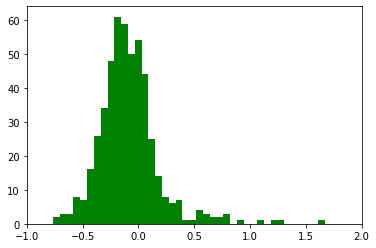

In [7]:
ax = plt.hist(final_df['One-Year Price Return'].astype('float'), 50, facecolor='g')
plt.xlim(-1, 2)

## Removing Low-Momentum Stocks

The investment strategy that we're building seeks to identify the 50 highest-momentum stocks in the S&P 500.

Because of this, the next thing we need to do is remove all the stocks in our DataFrame that fall below this momentum threshold. We'll sort the DataFrame by the stocks' one-year price return, and drop all stocks outside the top 50.


In [8]:
final_df.sort_values('One-Year Price Return', ascending=False, inplace=True)
final_df = final_df[0:50]
final_df.reset_index(inplace=True, drop=True)
final_df

,Ticker,Price,One-Year Price Return,Number of Shares to Buy
0,LB,82.52,2.284304,N/A
1,DVN,69.69,1.616321,N/A
2,OXY,60.99,1.260322,N/A
3,MRO,29.47,1.230578,N/A
4,APA,47.22,1.082758,N/A
5,COP,111.44,0.930718,N/A
6,CF,94.69,0.808792,N/A
7,PXD,270.98,0.795735,N/A
8,FANG,147.11,0.77909,N/A
9,VLO,133,0.733006,N/A


## Calculating the Number of Shares to Buy

Just like in the last project, we now need to calculate the number of shares we need to buy. The one change we're going to make is wrapping this functionality inside a function, since we'll be using it again later in this Jupyter Notebook.

Since we've already done most of the work on this, try to complete the following two code cells without watching me do it first!

In [9]:
def set_portfolio_size():
    portfolio_input = input('Enter the size of your portfolio:')
    
    try:
        float(portfolio_input)
        return portfolio_input
    except ValueError:
        print('That is not a number...\nPlease Try Again')
        portfolio_input = set_portfolio_size()
        return portfolio_input

portfolio_size = set_portfolio_size()
print('Portfolio Size:', portfolio_size)

Portfolio Size: 1e7


In [10]:
position_size = float(portfolio_size) / len(final_df.index)
print('Position Size:', position_size)

for i in range(len(final_df.index)):
    final_df.loc[i, 'Number of Shares to Buy'] = math.floor(position_size/final_df.loc[i, 'Price'])

final_df   

Position Size: 200000.0


,Ticker,Price,One-Year Price Return,Number of Shares to Buy
0,LB,82.52,2.284304,2423
1,DVN,69.69,1.616321,2869
2,OXY,60.99,1.260322,3279
3,MRO,29.47,1.230578,6786
4,APA,47.22,1.082758,4235
5,COP,111.44,0.930718,1794
6,CF,94.69,0.808792,2112
7,PXD,270.98,0.795735,738
8,FANG,147.11,0.77909,1359
9,VLO,133,0.733006,1503


## Building a Better (and More Realistic) Momentum Strategy

Real-world quantitative investment firms differentiate between "high quality" and "low quality" momentum stocks:

* High-quality momentum stocks show "slow and steady" outperformance over long periods of time
* Low-quality momentum stocks might not show any momentum for a long time, and then surge upwards.

The reason why high-quality momentum stocks are preferred is because low-quality momentum can often be cause by short-term news that is unlikely to be repeated in the future (such as an FDA approval for a biotechnology company).

To identify high-quality momentum, we're going to build a strategy that selects stocks from the highest percentiles of: 

* 1-month price returns
* 3-month price returns
* 6-month price returns
* 1-year price returns

Let's start by building our DataFrame. You'll notice that I use the abbreviation `hqm` often. It stands for `high-quality momentum`.

In [11]:
hqm_columns = [ 'Ticker', 'Company Name', 'Price', 'Number of Shares to Buy']

timeframes = ['One-Year', 'Six-Month', 'Three-Month', 'One-Month']
for i in range(4):
    hqm_columns.append(timeframes[i] + ' Price Return')
    hqm_columns.append(timeframes[i] + ' Return Percentile')

hqm_df = pd.DataFrame(columns = hqm_columns)
hqm_df

,Ticker,Company Name,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile


In [12]:
timeframes = ['year1', 'month6', 'month3', 'month1']

for symbol_string in symbol_strings:
    batch_api_url = f'https://sandbox.iexapis.com/stable/stock/market/batch?symbols={symbol_string}&types=price,stats&token={IEX_CLOUD_API_TOKEN}'
    batch_data = requests.get(batch_api_url).json()

    for symbol in symbol_string.split(','):
        if (symbol in batch_data):
            info = [symbol]
            info.append(batch_data[symbol]['stats']['companyName'])
            info.append(batch_data[symbol]['price'])
            info.append('N/A')
            for i in range(4):
                info.append(batch_data[symbol]['stats'][timeframes[i]+'ChangePercent'])
                info.append('N/A')

            hqm_df = pd.concat([hqm_df, pd.DataFrame([info], columns=hqm_columns)], ignore_index=True)
        else:
            print('Missiing Symbol:', symbol)

Missiing Symbol: DISCA
Missiing Symbol: HFC
Missiing Symbol: VIAC
Missiing Symbol: WLTW


In [13]:
hqm_df

,Ticker,Company Name,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile
0,A,Agilent Technologies Inc.,116.87,N/A,-0.1961,N/A,-0.245196,N/A,-0.093025,N/A,-0.029191,N/A
1,AAL,American Airlines Group Inc,13.53,N/A,-0.458514,N/A,-0.24248,N/A,-0.091813,N/A,-0.228462,N/A
2,AAP,Advance Auto Parts Inc,179.3,N/A,-0.119874,N/A,-0.275513,N/A,-0.134731,N/A,-0.194937,N/A
3,AAPL,Apple Inc,135.89,N/A,0.024071,N/A,-0.241767,N/A,-0.122299,N/A,-0.100828,N/A
4,ABBV,Abbvie Inc,144.04,N/A,0.246,N/A,0.105125,N/A,-0.090837,N/A,-0.107412,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...
496,YUM,Yum Brands Inc.,116.5,N/A,-0.050765,N/A,-0.158233,N/A,-0.024381,N/A,-0.018241,N/A
497,ZBH,Zimmer Biomet Holdings Inc,110.63,N/A,-0.341794,N/A,-0.14757,N/A,-0.107168,N/A,-0.085721,N/A
498,ZBRA,Zebra Technologies Corp.,311.28,N/A,-0.426239,N/A,-0.495889,N/A,-0.211506,N/A,-0.107502,N/A
499,ZION,Zions Bancorporation N.A,54.45,N/A,-0.040826,N/A,-0.174779,N/A,-0.212342,N/A,-0.033792,N/A


In [14]:
hqm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Ticker                         501 non-null    object
 1   Company Name                   501 non-null    object
 2   Price                          501 non-null    object
 3   Number of Shares to Buy        501 non-null    object
 4   One-Year Price Return          497 non-null    object
 5   One-Year Return Percentile     501 non-null    object
 6   Six-Month Price Return         497 non-null    object
 7   Six-Month Return Percentile    501 non-null    object
 8   Three-Month Price Return       497 non-null    object
 9   Three-Month Return Percentile  501 non-null    object
 10  One-Month Price Return         497 non-null    object
 11  One-Month Return Percentile    501 non-null    object
dtypes: object(12)
memory usage: 47.1+ KB


In [15]:
hqm_df[hqm_df['One-Year Price Return'].isnull()]

,Ticker,Company Name,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile
118,CTL,"CenturyLink, Inc.",11,N/A,None,N/A,None,N/A,None,N/A,None,N/A
164,ETFC,E*TRADE Financial Corp.,50.53,N/A,None,N/A,None,N/A,None,N/A,None,N/A
324,MYL,Mylan NV,15.891,N/A,None,N/A,None,N/A,None,N/A,None,N/A
325,NBL,"Noble Energy, Inc.",8.76,N/A,None,N/A,None,N/A,None,N/A,None,N/A


In [16]:
hqm_df.drop(index=hqm_df[hqm_df['One-Year Price Return'].isnull()].index, inplace=True)

## Calculating Momentum Percentiles

We now need to calculate momentum percentile scores for every stock in the universe. More specifically, we need to calculate percentile scores for the following metrics for every stock:

* `One-Year Price Return`
* `Six-Month Price Return`
* `Three-Month Price Return`
* `One-Month Price Return`

Here's how we'll do this:

In [17]:
timeframes = ['One-Year', 'Six-Month', 'Three-Month', 'One-Month']

for row in hqm_df.index:
    for timeframe in timeframes:
        hqm_df.loc[row, f'{timeframe} Return Percentile'] = score(hqm_df[f'{timeframe} Price Return'], hqm_df.loc[row, f'{timeframe} Price Return']) / 100

hqm_df

,Ticker,Company Name,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile
0,A,Agilent Technologies Inc.,116.87,N/A,-0.1961,0.334004,-0.245196,0.311871,-0.093025,0.484909,-0.029191,0.770624
1,AAL,American Airlines Group Inc,13.53,N/A,-0.458514,0.044266,-0.24248,0.313883,-0.091813,0.49497,-0.228462,0.016097
2,AAP,Advance Auto Parts Inc,179.3,N/A,-0.119874,0.492958,-0.275513,0.241449,-0.134731,0.374245,-0.194937,0.032193
3,AAPL,Apple Inc,135.89,N/A,0.024071,0.744467,-0.241767,0.317907,-0.122299,0.410463,-0.100828,0.277666
4,ABBV,Abbvie Inc,144.04,N/A,0.246,0.925553,0.105125,0.871227,-0.090837,0.498994,-0.107412,0.245473
...,...,...,...,...,...,...,...,...,...,...,...,...
496,YUM,Yum Brands Inc.,116.5,N/A,-0.050765,0.607646,-0.158233,0.509054,-0.024381,0.71831,-0.018241,0.820926
497,ZBH,Zimmer Biomet Holdings Inc,110.63,N/A,-0.341794,0.128773,-0.14757,0.531187,-0.107168,0.450704,-0.085721,0.38833
498,ZBRA,Zebra Technologies Corp.,311.28,N/A,-0.426239,0.060362,-0.495889,0.016097,-0.211506,0.140845,-0.107502,0.243461
499,ZION,Zions Bancorporation N.A,54.45,N/A,-0.040826,0.633803,-0.174779,0.476861,-0.212342,0.136821,-0.033792,0.744467


## Calculating the HQM Score

We'll now calculate our `HQM Score`, which is the high-quality momentum score that we'll use to filter for stocks in this investing strategy.

The `HQM Score` will be the arithmetic mean of the 4 momentum percentile scores that we calculated in the last section.

To calculate arithmetic mean, we will use the `mean` function from Python's built-in `statistics` module.

In [18]:
from statistics import mean

hqm_score = []

for row in hqm_df.index:
    momentum_percentiles = []
    for timeframe in timeframes:
        momentum_percentiles.append(hqm_df.loc[row, f'{timeframe} Return Percentile'])
    hqm_score.append(mean(momentum_percentiles))

hqm_df['HQM Score'] = hqm_score
hqm_df

,Ticker,Company Name,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile,HQM Score
0,A,Agilent Technologies Inc.,116.87,N/A,-0.1961,0.334004,-0.245196,0.311871,-0.093025,0.484909,-0.029191,0.770624,0.475352
1,AAL,American Airlines Group Inc,13.53,N/A,-0.458514,0.044266,-0.24248,0.313883,-0.091813,0.49497,-0.228462,0.016097,0.217304
2,AAP,Advance Auto Parts Inc,179.3,N/A,-0.119874,0.492958,-0.275513,0.241449,-0.134731,0.374245,-0.194937,0.032193,0.285211
3,AAPL,Apple Inc,135.89,N/A,0.024071,0.744467,-0.241767,0.317907,-0.122299,0.410463,-0.100828,0.277666,0.437626
4,ABBV,Abbvie Inc,144.04,N/A,0.246,0.925553,0.105125,0.871227,-0.090837,0.498994,-0.107412,0.245473,0.635312
...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,YUM,Yum Brands Inc.,116.5,N/A,-0.050765,0.607646,-0.158233,0.509054,-0.024381,0.71831,-0.018241,0.820926,0.663984
497,ZBH,Zimmer Biomet Holdings Inc,110.63,N/A,-0.341794,0.128773,-0.14757,0.531187,-0.107168,0.450704,-0.085721,0.38833,0.374748
498,ZBRA,Zebra Technologies Corp.,311.28,N/A,-0.426239,0.060362,-0.495889,0.016097,-0.211506,0.140845,-0.107502,0.243461,0.115191
499,ZION,Zions Bancorporation N.A,54.45,N/A,-0.040826,0.633803,-0.174779,0.476861,-0.212342,0.136821,-0.033792,0.744467,0.497988


## Selecting the 50 Best Momentum Stocks

As before, we can identify the 50 best momentum stocks in our universe by sorting the DataFrame on the `HQM Score` column and dropping all but the top 50 entries.

In [19]:
hqm_df.sort_values('HQM Score', ascending=False, inplace=True)
hqm_df.reset_index(inplace=True, drop=True)
hqm_df = hqm_df[0:50]
hqm_df

,Ticker,Company Name,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile,HQM Score
0,APA,APA Corporation,46.89,N/A,1.092787,0.991952,0.864247,0.993964,0.236619,0.975855,0.118233,0.995976,0.989437
1,VLO,Valero Energy Corp.,132.4,N/A,0.744939,0.981891,1.036763,0.997988,0.494148,1.0,0.074104,0.973843,0.988431
2,MRO,Marathon Oil Corporation,28.76,N/A,1.229171,0.995976,0.931383,0.995976,0.305621,0.987928,0.070754,0.967807,0.986922
3,LB,L Brands Inc,83.53,N/A,2.370788,1.0,0.846065,0.991952,0.216012,0.973843,0.081138,0.977867,0.985915
4,DVN,Devon Energy Corp.,71.13,N/A,1.647548,0.997988,0.827845,0.98994,0.375367,0.997988,0.045604,0.95171,0.984406
5,MPC,Marathon Petroleum Corp,101.5,N/A,0.716999,0.979879,0.697373,0.987928,0.35432,0.98994,0.080034,0.975855,0.983400
6,COP,Conoco Phillips,114.23,N/A,0.934786,0.98994,0.611396,0.981891,0.17121,0.963783,0.092489,0.983903,0.979879
7,FANG,Diamondback Energy Inc,154.04,N/A,0.787732,0.985915,0.468782,0.965795,0.200645,0.969819,0.124237,0.997988,0.979879
8,XOM,Exxon Mobil Corp.,95.34,N/A,0.643383,0.975855,0.615471,0.983903,0.191214,0.967807,0.083786,0.979879,0.976861
9,HRB,H&R Block Inc.,34.87,N/A,0.423398,0.957746,0.493303,0.969819,0.3722,0.995976,0.072697,0.971831,0.973843


## Calculating the Number of Shares to Buy

We'll use the `portfolio_input` function that we created earlier to accept our portfolio size. Then we will use similar logic in a `for` loop to calculate the number of shares to buy for each stock in our investment universe.

In [20]:
portfolio_size = set_portfolio_size()
print('Portfolio Size:', portfolio_size)

Portfolio Size: 1e7


In [21]:
position_size = float(portfolio_size) / len(hqm_df.index)
print('Position Size:', position_size)

Position Size: 200000.0


In [22]:
for i in hqm_df.index:
    hqm_df.loc[i, 'Number of Shares to Buy'] = math.floor(position_size/hqm_df['Price'][i])

hqm_df

,Ticker,Company Name,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile,HQM Score
0,APA,APA Corporation,46.89,4265,1.092787,0.991952,0.864247,0.993964,0.236619,0.975855,0.118233,0.995976,0.989437
1,VLO,Valero Energy Corp.,132.4,1510,0.744939,0.981891,1.036763,0.997988,0.494148,1.0,0.074104,0.973843,0.988431
2,MRO,Marathon Oil Corporation,28.76,6954,1.229171,0.995976,0.931383,0.995976,0.305621,0.987928,0.070754,0.967807,0.986922
3,LB,L Brands Inc,83.53,2394,2.370788,1.0,0.846065,0.991952,0.216012,0.973843,0.081138,0.977867,0.985915
4,DVN,Devon Energy Corp.,71.13,2811,1.647548,0.997988,0.827845,0.98994,0.375367,0.997988,0.045604,0.95171,0.984406
5,MPC,Marathon Petroleum Corp,101.5,1970,0.716999,0.979879,0.697373,0.987928,0.35432,0.98994,0.080034,0.975855,0.983400
6,COP,Conoco Phillips,114.23,1750,0.934786,0.98994,0.611396,0.981891,0.17121,0.963783,0.092489,0.983903,0.979879
7,FANG,Diamondback Energy Inc,154.04,1298,0.787732,0.985915,0.468782,0.965795,0.200645,0.969819,0.124237,0.997988,0.979879
8,XOM,Exxon Mobil Corp.,95.34,2097,0.643383,0.975855,0.615471,0.983903,0.191214,0.967807,0.083786,0.979879,0.976861
9,HRB,H&R Block Inc.,34.87,5735,0.423398,0.957746,0.493303,0.969819,0.3722,0.995976,0.072697,0.971831,0.973843


## Formatting Our Excel Output

We will be using the XlsxWriter library for Python to create nicely-formatted Excel files.

XlsxWriter is an excellent package and offers tons of customization. However, the tradeoff for this is that the library can seem very complicated to new users. Accordingly, this section will be fairly long because I want to do a good job of explaining how XlsxWriter works.

In [23]:
writer = pd.ExcelWriter('momentum_recommended_trades.xlsx', engine='xlsxwriter')

hqm_df.to_excel(writer, sheet_name='Momentum Strategy', index=False)

## Creating the Formats We'll Need For Our .xlsx File

You'll recall from our first project that formats include colors, fonts, and also symbols like % and $. We'll need four main formats for our Excel document:

* String format for tickers
* \$XX.XX format for stock prices
* \$XX,XXX format for market capitalization
* Integer format for the number of shares to purchase

Since we already built our formats in the last section of this course, I've included them below for you. Run this code cell before proceeding.

In [24]:
background_color = '#0a0a23'
font_color = '#ffffff'

string_template = writer.book.add_format(
        {
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

dollar_template = writer.book.add_format(
        {
            'num_format':'$0.00',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

integer_template = writer.book.add_format(
        {
            'num_format':'0',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

percent_template = writer.book.add_format(
        {
            'num_format':'0.0%',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

score_template = writer.book.add_format(
        {
            'num_format':'0.00',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

In [25]:
hqm_df_columns = hqm_df.columns
hqm_df_columns

Index(['Ticker', 'Company Name', 'Price', 'Number of Shares to Buy',
       'One-Year Price Return', 'One-Year Return Percentile',
       'Six-Month Price Return', 'Six-Month Return Percentile',
       'Three-Month Price Return', 'Three-Month Return Percentile',
       'One-Month Price Return', 'One-Month Return Percentile', 'HQM Score'],
      dtype='object')

In [26]:
column_formats = {
    'A': [hqm_df_columns[0], string_template],
    'B': [hqm_df_columns[1], string_template],
    'C': [hqm_df_columns[2], dollar_template],
    'D': [hqm_df_columns[3], integer_template],
    'E': [hqm_df_columns[4], percent_template],
    'F': [hqm_df_columns[5], percent_template],
    'G': [hqm_df_columns[6], percent_template],
    'H': [hqm_df_columns[7], percent_template],
    'I': [hqm_df_columns[8], percent_template],
    'J': [hqm_df_columns[9], percent_template],
    'K': [hqm_df_columns[10], percent_template],
    'L': [hqm_df_columns[11], percent_template],
    'M': [hqm_df_columns[12], score_template]
}

for column in column_formats.keys():
    writer.sheets['Momentum Strategy'].set_column(f'{column}:{column}', 25, column_formats[column][1])
    writer.sheets['Momentum Strategy'].write(f'{column}1', column_formats[column][0], string_template)

## Saving Our Excel Output

As before, saving our Excel output is very easy:

In [27]:
writer.save()